<a href="https://colab.research.google.com/github/vineeth995/ThesisScripts/blob/main/UFI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 5000)
from sklearn.preprocessing import MinMaxScaler,StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error,explained_variance_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import AdaBoostRegressor,GradientBoostingRegressor
from xgboost import XGBRegressor
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pandas_profiling import ProfileReport
from sklearn.preprocessing import LabelEncoder
from sklearn.inspection import permutation_importance

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data=pd.read_csv("/content/drive/My Drive/House_Prices/immo_data.csv")

Mounted at /content/drive


In [ ]:
data_cat=pd.read_csv("/content/drive/My Drive/House_Prices/immo_data.csv")
data_cat=data_cat.drop(['telekomHybridUploadSpeed','picturecount','scoutId','noParkSpaces','date','electricityKwhPrice','electricityBasePrice','description','street','streetPlain','houseNumber','telekomTvOffer','telekomUploadSpeed','lastRefurbish','energyEfficiencyClass','heatingCosts','regio3','facilities'
,'livingSpaceRange','noRoomsRange','baseRentRange','thermalChar','petsAllowed','geo_bln','geo_krs','serviceCharge','pricetrend','totalRent','yearConstructedRange','yearConstructed','firingTypes','regio1','regio2','numberOfFloors'],axis=1)
data_cat = data_cat.dropna(subset=['heatingType','newlyConst','balcony','hasKitchen','cellar','baseRent','livingSpace','condition','interiorQual','lift','typeOfFlat','geo_plz','noRooms','floor','garden'],inplace=False)

In [ ]:
#Run if you want encoding
#dont use for catboost
lbl_enc = LabelEncoder()
data_cat.loc[:, "heatingType"] = lbl_enc.fit_transform(data_cat.heatingType.values)
data_cat.loc[:, "condition"] = lbl_enc.fit_transform(data_cat.condition.values)
data_cat.loc[:, "interiorQual"] = lbl_enc.fit_transform(data_cat.interiorQual.values)
data_cat.loc[:, "typeOfFlat"] = lbl_enc.fit_transform(data_cat.typeOfFlat.values)
data_cat.loc[:, "geo_plz"] = lbl_enc.fit_transform(data_cat.geo_plz.values)

In [ ]:
#if you want to encode enum values
def balkon(row):
    if row['balcony']==True:
        return 1
    elif row['balcony']==False:
        return 0    
    
def kitchen(row):
    if row['hasKitchen']==True:
        return 1
    elif row['hasKitchen']==False:
        return 0    
    
def cellar(row):
    if row['cellar']==True:
        return 1
    elif row['cellar']==False:
        return 0    
 
def lift(row):
    if row['lift']==True:
        return 1
    elif row['lift']==False:
        return 0

def garden(row):
    if row['garden']==True:
        return 1
    elif row['garden']==False:
        return 0 

def newlyConst(row):
    if row['newlyConst']==True:
      return 1
    else: 
      return 0  

data_cat['balcony']=data_cat.apply(lambda row: balkon(row),axis=1)
data_cat['hasKitchen']=data_cat.apply(lambda row: kitchen(row),axis=1)
data_cat['cellar']=data_cat.apply(lambda row: cellar(row),axis=1)
data_cat['lift']=data_cat.apply(lambda row: lift(row),axis=1)
data_cat['garden']=data_cat.apply(lambda row: garden(row),axis=1)
data_cat['newlyConst']=data_cat.apply(lambda row: newlyConst(row),axis=1)   

data_cat['balcony'] = data_cat.balcony.astype('int')
data_cat['balcony'] = data_cat.balcony.astype('category')
data_cat['hasKitchen'] = data_cat.hasKitchen.astype('int')
data_cat['hasKitchen'] = data_cat.hasKitchen.astype('category')
data_cat['cellar'] = data_cat.cellar.astype('int')
data_cat['cellar'] = data_cat.cellar.astype('category')
data_cat['lift'] = data_cat.lift.astype('int')
data_cat['lift'] = data_cat.lift.astype('category')
data_cat['garden'] = data_cat.garden.astype('int')
data_cat['garden'] = data_cat.garden.astype('category')
data_cat['newlyConst'] = data_cat.newlyConst.astype('int')
data_cat['newlyConst'] = data_cat.newlyConst.astype('category')

In [ ]:
#trimming extreme values
data_cat.drop(data_cat[(data_cat['baseRent'] > 8000) | (data_cat['baseRent'] < 100)].index, inplace = True ,axis = 0)
data_cat.drop(data_cat[(data_cat['livingSpace'] >= 2420) | (data_cat['livingSpace'] < 10)].index, inplace = True, axis = 0)
data_cat.drop(data_cat[(data_cat['livingSpace'] < 100) & (data_cat['baseRent'] > 4000)].index, inplace = True, axis = 0)
data_cat.drop(data_cat[(data_cat['noRooms'] > 15)].index, inplace = True, axis = 0)

In [ ]:
#setting floors as category 
data_cat['noRooms'] = data_cat.noRooms.astype('int')
data_cat['floor'] = data_cat.floor.astype('int')
data_cat['floor'] = data_cat.floor.astype('category')

In [ ]:
data_cat['geo_plz'] = data_cat.geo_plz.astype('category')
data_cat['typeOfFlat'] = data_cat.typeOfFlat.astype('category')
data_cat['condition'] = data_cat.condition.astype('category')
data_cat['interiorQual'] = data_cat.interiorQual.astype('category')
data_cat['heatingType'] = data_cat.heatingType.astype('category')

In [ ]:
data_cat.head(5)

,heatingType,newlyConst,balcony,hasKitchen,cellar,baseRent,livingSpace,condition,interiorQual,lift,typeOfFlat,geo_plz,noRooms,floor,garden
0,0,0,0,0,1,595.0,86.00,9,1,0,1,2619,4,1,1
2,4,1,1,0,1,965.0,83.80,0,3,1,0,4,3,3,0
8,8,0,0,1,1,580.0,53.00,9,3,0,8,4903,2,2,0
9,9,0,0,0,1,300.0,60.00,9,1,0,0,2752,2,2,0
13,0,0,0,0,0,950.0,123.44,1,3,0,0,3560,4,4,0


In [ ]:
data_cat.dtypes

heatingType     category
newlyConst      category
balcony         category
hasKitchen      category
cellar          category
baseRent         float64
livingSpace      float64
condition       category
interiorQual    category
lift            category
typeOfFlat      category
geo_plz         category
noRooms            int64
floor           category
garden          category
dtype: object

In [ ]:
#splitting X and y variables
y_cat=data_cat['baseRent']
X_cat=data_cat.drop(['baseRent'],axis=1)

In [ ]:
#splitting into testing and training sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_cat, y_cat)

In [ ]:
gbr= GradientBoostingRegressor(n_estimators = 100)
gbr.fit(X_train, y_train)
    
    

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
y_pred=gbr.predict(X_test)

In [ ]:
r2_score(y_test,y_pred)

0.8398745366497598

In [ ]:
gbr.feature_importances_

array([6.93808803e-05, 6.46208761e-04, 3.03543510e-03, 2.46558225e-02,
       2.47978029e-04, 6.31012737e-01, 2.50723293e-02, 1.00173830e-01,
       4.47379056e-02, 0.00000000e+00, 1.65209264e-01, 6.86103065e-04,
       4.45300512e-03, 0.00000000e+00])

In [ ]:
importances = gbr.feature_importances_
indices = np.argsort(importances)

In [ ]:
features=list(X_train.columns)

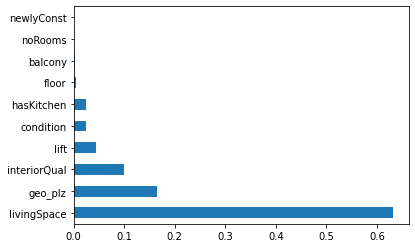

In [ ]:
feat_importances = pd.Series(gbr.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')

In [ ]:
import numpy as np
from sklearn.utils import check_random_state

def _generate_sample_indices(random_state, n_samples):
    """Private function used to _parallel_build_trees function."""
    random_instance = check_random_state(random_state)
    sample_indices = random_instance.randint(0, n_samples, n_samples)

    return sample_indices



def inbag_times_(mod, X):
    """ Return n_samples by n_estimators array which keeps track of which samples are
        "in-bag" in which trees for how many times.
    Parameters  
    ----------
    self : RandomForest object. 
    X : array-like of shape = [n_samples, n_features]
    The training input samples. It should be the same data as you use to fit RandomForest. 
    Returns
    -------
    inbag_times_ : array, shape = [n_samples, n_estimators]
    """
    n_samples = X.shape[0]
    inbag = np.zeros((n_samples, mod.n_estimators))
    for t_idx in range(mod.n_estimators):
        sample_idx = _generate_sample_indices(mod.estimators_[t_idx].random_state, n_samples)
        inbag[:, t_idx] = np.bincount(sample_idx, minlength = n_samples)

    return inbag




def regr(mod, X, y):
    """Return unbiased measurement of feature importance for RandomForestRegressor using out-of-bag samples.
    Parameters  
    ----------
    self : RandomForestRegressor object. 
    X : array-like of shape = [n_samples, n_features]
        The training input samples. It should be the same data as you use to fit RandomForestRegressor.
    y : array-like of shape = [n_samples]
        The target values (real numbers in regression). 
    Returns
    -------
    feature importance: array, shape = [n_features]
    """   
    VI = np.array([0.] * mod.n_features_)
    print('VI Initial Value:',VI)

    n_estimators = mod.n_estimators
    print('Estimators:' ,n_estimators)

    #inbag = inbag_times_(mod, X)
    #print('Inbag',inbag)
    


    for index, tree in enumerate(mod.estimators_):

        temp = np.array([0.] * mod.n_features_)

        n_nodes = tree[0].tree_.node_count

        x1,x2,y1,y2=train_test_split(X,y,test_size=0.50)
        
        #tree_X_inb = X.repeat((inbag[:, index]).astype("int"), axis = 0)
        tree_X_inb = x1
        print('tree x inb:',tree_X_inb)
        #tree_y_inb = y.repeat((inbag[:, index]).astype("int"), axis = 0)
        tree_y_inb = y1
        print('tree y inb',tree_y_inb)
        decision_path_inb = tree[0].decision_path(tree_X_inb).todense()
        print('dec path inb',decision_path_inb)

        #tree_X_oob = X[inbag[:, index] == 0]
        tree_X_oob = x2
        print('tree x oob',tree_X_oob)
        #tree_y_oob = y[inbag[:, index] == 0]
        tree_y_oob = y2
        print('tree y oob',tree_y_oob)
        decision_path_oob = tree[0].decision_path(tree_X_oob).todense()
        print('dec path oob',decision_path_oob)

        impurity_train = tree[0].tree_.impurity
        impurity = [0] * n_nodes

        flag = [True] * n_nodes

        print("sum of decpath")
        print(np.sum(decision_path_inb, axis = 0))
        print("***")
        print(np.array(np.sum(decision_path_inb, axis = 0)))
        print("***")
        print(tree_X_inb.shape[0])
        print("****")
        print(np.array(np.sum(decision_path_inb, axis = 0))[0])
        weighted_n_node_samples = np.array(np.sum(decision_path_inb, axis = 0))[0] / tree_X_inb.shape[0]
        print("***")
        print(weighted_n_node_samples)

        for i in range(n_nodes):

            arr1 = tree_y_oob.iloc[np.array(decision_path_oob[:, i]).ravel().nonzero()[0].tolist()]
            arr2 = tree_y_inb.iloc[np.array(decision_path_inb[:, i]).ravel().nonzero()[0].tolist()]
            
            print("t-5")

            if len(arr1) == 0:
                if sum(tree[0].tree_.children_left == i) > 0:
                    parent_node = np.arange(n_nodes)[tree[0].tree_.children_left == i][0]
                    flag[parent_node] = False
                else:
                    parent_node = np.arange(n_nodes)[tree[0].tree_.children_right == i][0]
                    flag[parent_node] = False
            else:
                print(np.isnan(arr2).any())
                shit=np.mean(arr2)
                numerator = np.sum((arr1 - shit) ** 2) 
                denominator=len(arr1)
                impurity[i] = numerator/denominator

            print("t-4")    

        for node in range(n_nodes):

            if tree[0].tree_.children_left[node] == -1 or tree[0].tree_.children_right[node] == -1:
                continue

            v = tree[0].tree_.feature[node]

            node_left = tree[0].tree_.children_left[node]
            node_right = tree[0].tree_.children_right[node]

            print("Main engine start")

            if flag[node] == True:

                incre = (weighted_n_node_samples[node] * (impurity[node] + impurity_train[node]) -
                         weighted_n_node_samples[node_left] * (impurity[node_left] + impurity_train[node_left]) - 
                         weighted_n_node_samples[node_right] * (impurity_train[node_right] + impurity[node_right]))

                temp[v] += incre
       
        VI += temp 

    return VI / n_estimators

In [ ]:
All = []
model_check = GradientBoostingRegressor(n_estimators = 100)
modle.fit(X_train, y_train)

All.append(regr(model_check, X_cat, y_cat))
import math

imp = np.mean(All, axis = 0)

std = np.std(All, axis = 0)

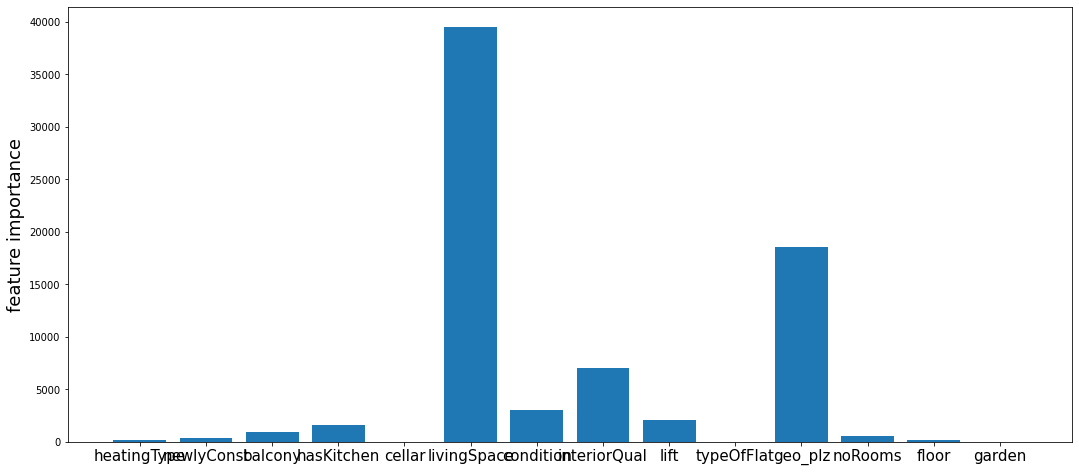

In [ ]:
plt.figure(figsize=(18, 8))

imp_name = X_train.columns
pos = np.arange(len(imp_name))
bars = imp_name

barlist = plt.bar(pos, imp, yerr = std, ecolor = "red")
barlist[-1].set_color('black')
plt.xticks(pos, bars, fontsize = 15)

plt.ylabel("feature importance", fontsize = 18)

plt.savefig("UFI_on_boston_data.png")

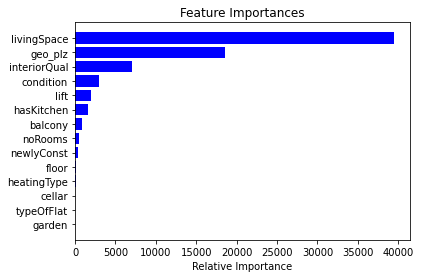

In [ ]:
features_ufi = X_train.columns
importances_ufi = np.mean(All, axis = 0)
indices = np.argsort(importances_ufi)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances_ufi[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [ ]:
importances = gbr.feature_importances_
indices = np.argsort(importances)


